# Clustering With Weather Data

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium 

import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from collections import Counter

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [12]:
# load species data for each park

species = pd.read_csv('all_species.csv')
species.drop(species.columns[species.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
species

/var/folders/vb/bprs19k12d92r7xpmxnv1rx40000gn/T/ipykernel_61142/1340857715.py:3: DtypeWarning: Columns (3,12,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv('all_species.csv')


,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Park Code
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,ACAD
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,ACAD
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,ACAD
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,ACAD
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,ACAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169723,NaN,White Sands National Park,Vascular Plant,Solanales,Solanaceae,Lycium pallidum,pale wolfberry,Approved,Present,NaN,Unknown,NaN,NaN,WHSA
169724,NaN,White Sands National Park,Vascular Plant,Solanales,Solanaceae,Lycium torreyi,Torrey wolfberry,Approved,Present,NaN,Unknown,NaN,NaN,WHSA
169725,NaN,White Sands National Park,Vascular Plant,Solanales,Solanaceae,Solanum elaeagnifolium,silverleaf nightshade,Approved,Present,NaN,Unknown,NaN,NaN,WHSA
169726,NaN,White Sands National Park,Vascular Plant,Zygophyllales,Zygophyllaceae,Kallstroemia hirsutissima,carpetweed,Approved,Present,NaN,Unknown,NaN,NaN,WHSA


In [13]:
# load location data for each park

locations = pd.read_csv('locations.csv')
locations.drop(locations.columns[locations.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
locations

,Park Code,Park Name,State,Acres,Latitude,Longitude,present
0,ACAD,Acadia National Park,ME,47390,44.3500,-68.2100,1
1,ARCH,Arches National Park,UT,76519,38.6800,-109.5700,1
2,BADL,Badlands National Park,SD,242756,43.7500,-102.5000,1
3,BIBE,Big Bend National Park,TX,801163,29.2500,-103.2500,1
4,BISC,Biscayne National Park,FL,172924,25.6500,-80.0800,1
...,...,...,...,...,...,...,...
56,INDU,Indiana Dunes National Park,IN,15066,41.6506,-87.0708,0
57,NPSA,National Park of American Samoa,AS,13500,14.2583,170.6833,0
58,NERI,New River Gorge National Park,WV,72808,37.8752,-81.0357,0
59,VIIS,Virgin Islands National Park,VI,12909,18.3435,64.7501,0


In [14]:
weather = pd.read_csv('NPS_weather_trends.csv')
park_weather = weather[['ParkName', 'Month', 'Year', 'Temp_Avg_Fahrenheit', 'Prcp_Avg_Inches']]

# filter for 10 yr avg
park_weather = park_weather[park_weather['Year'] >= 2011]
park_weather.head()

,ParkName,Month,Year,Temp_Avg_Fahrenheit,Prcp_Avg_Inches
72,Acadia National Park,1,2011,22.30,3.911
73,Acadia National Park,2,2011,23.30,3.908
74,Acadia National Park,3,2011,30.82,3.359
75,Acadia National Park,4,2011,41.60,4.482
76,Acadia National Park,5,2011,52.18,3.817


In [15]:
# get 10-year averages for each month for each park
avg_10_yr = park_weather.groupby(['ParkName','Month']).agg('mean').reset_index().drop(columns = 'Year')
avg_10_yr.rename(columns = {'ParkName':'park', 'Month':'month','Temp_Avg_Fahrenheit':'temp', 'Prcp_Avg_Inches':'prcp'}, inplace = True)
#avg_10_yr.drop(columns = 'prcp', inplace = True)
avg_10_yr.head()

,park,month,temp,prcp
0,Acadia National Park,1,22.30,3.911
1,Acadia National Park,2,23.30,3.908
2,Acadia National Park,3,30.82,3.359
3,Acadia National Park,4,41.60,4.482
4,Acadia National Park,5,52.18,3.817


In [16]:
# specify user input month
avg_10_yr = avg_10_yr[avg_10_yr['month'] == 6]
avg_10_yr

,park,month,temp,prcp
5,Acadia National Park,6,60.85,4.831
17,Arches National Park,6,76.91,0.311
29,Badlands National Park,6,69.79,3.565
41,Big Bend National Park,6,78.12,1.654
53,Biscayne National Park,6,83.51,6.020
...,...,...,...,...
701,Wind Cave National Park,6,62.56,3.409
713,Wrangell-St. Elias National Park,6,47.83,1.555
725,Yellowstone National Park,6,51.05,1.767
737,Yosemite National Park,6,73.59,0.270


In [17]:
# fix naming inconsistencies 
for park in list(avg_10_yr['park'].unique()):
    if park not in list(species['Park Name'].unique()):
        print(park)

Gates of the Arctic National Park
Gateway Arch National Park
Kings Canyon National Park
New River Gorge National Park
Sequoia National Park
Wrangell-St. Elias National Park


In [18]:
from sklearn.preprocessing import StandardScaler

clus_temp = avg_10_yr[['temp']]

X = StandardScaler().fit_transform(clus_temp)

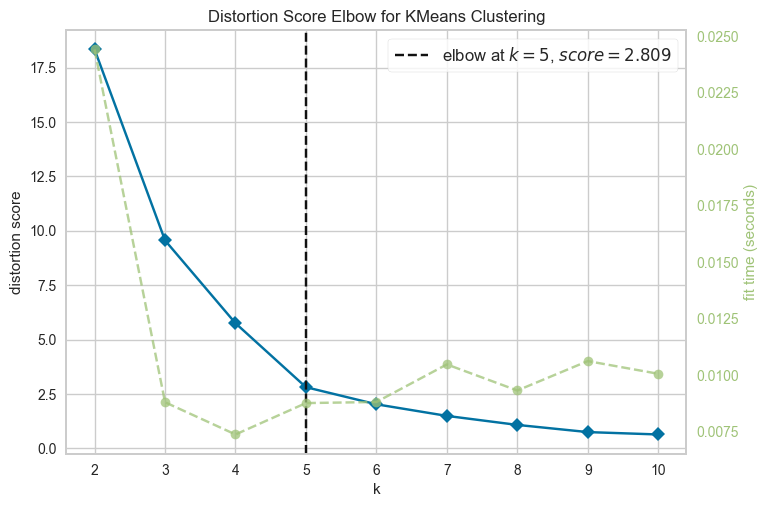

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
visualizer = KElbowVisualizer(KMeans(random_state = 42), k=(2,11))

visualizer.fit(X) # Fit the data to the visualizer
visualizer.show()

In [20]:
KM = KMeans(n_clusters = 5, random_state = 42)
#model = KM.fit(X)
temp_labels = KM.fit_predict(X)

labs = np.unique(temp_labels)
avg_10_yr['k_cluster'] = temp_labels
temp_merged = avg_10_yr.merge(locations, how = 'left', left_on = 'park', right_on = 'Park Name')
temp_merged

,park,month,temp,prcp,k_cluster,Park Code,Park Name,State,Acres,Latitude,Longitude,present
0,Acadia National Park,6,60.85,4.831,4,ACAD,Acadia National Park,ME,47390.0,44.35,-68.21,1.0
1,Arches National Park,6,76.91,0.311,1,ARCH,Arches National Park,UT,76519.0,38.68,-109.57,1.0
2,Badlands National Park,6,69.79,3.565,2,BADL,Badlands National Park,SD,242756.0,43.75,-102.50,1.0
3,Big Bend National Park,6,78.12,1.654,1,BIBE,Big Bend National Park,TX,801163.0,29.25,-103.25,1.0
4,Biscayne National Park,6,83.51,6.020,1,BISC,Biscayne National Park,FL,172924.0,25.65,-80.08,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
58,Wind Cave National Park,6,62.56,3.409,4,WICA,Wind Cave National Park,SD,28295.0,43.57,-103.48,1.0
59,Wrangell-St. Elias National Park,6,47.83,1.555,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,Yellowstone National Park,6,51.05,1.767,0,YELL,Yellowstone National Park,"WY, MT, ID",2219791.0,44.60,-110.50,1.0
61,Yosemite National Park,6,73.59,0.270,2,YOSE,Yosemite National Park,CA,761266.0,37.83,-119.50,1.0


In [21]:
# uncomment to see view map of uncleaned data

#temp_merged = temp_merged.dropna().reset_index(drop = True)

In [22]:
location_list = temp_merged[['Latitude', 'Longitude']].values.tolist()
park_names = temp_merged['Park Name'].tolist()

# assign colors to each cluster
def regioncolors(counter):
    if counter['k_cluster'] == 0:
        return 'darkblue'
    elif counter['k_cluster'] == 1:
        return 'darkred'
    elif counter['k_cluster'] == 2:
        return 'blue'
    elif counter['k_cluster'] == 3:
        return 'darkgreen'
    else:
        return 'darkpurple'
        
temp_merged['color'] = temp_merged.apply(regioncolors, axis = 1)

These park names need to be cleaned:

In [25]:
temp_merged[temp_merged['Park Name'].isna()]

,park,month,temp,prcp,k_cluster,Park Code,Park Name,State,Acres,Latitude,Longitude,present,color
15,Denali National Park,6,52.28,3.670,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darkblue
18,Gates of the Arctic National Park,6,53.67,1.519,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darkblue
19,Gateway Arch National Park,6,76.38,4.256,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darkred
20,Glacier Bay National Park,6,53.88,4.160,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darkblue
25,Great Sand Dunes National Park,6,58.43,0.745,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darkpurple
34,Katmai National Park,6,53.19,1.855,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darkblue
36,Kings Canyon National Park,6,70.16,0.270,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blue
38,Lake Clark National Park,6,52.15,1.696,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darkblue
52,Sequoia National Park,6,69.78,0.300,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blue
59,Wrangell-St. Elias National Park,6,47.83,1.555,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darkblue


In [52]:
print(len(temp_merged))
print(len(location_list))

63
63


In [53]:
us_map = folium.Map(tiles='CartoDB positron', zoom_start=14)

for point in range(0, len(location_list)):
    folium.Marker(location_list[point],popup=park_names[point], icon=folium.Icon(color=temp_merged["color"][point], icon_color='white', icon='star', angle=0, prefix='fa')).add_to(us_map)

display(us_map)

ValueError: Location values cannot contain NaNs.

### K-means Clustering Ex w/ Species Data

In [65]:
# new df with only species that are present 
present_sp = species[species['Occurrence'] == 'Present']

similarity_df = present_sp[['Park Name', 'Scientific Name', 'Park Code']]

In [66]:
# like of all park codes
park_codes = list(similarity_df['Park Code'].unique())

# list of all species in a park
code_sp_list = []
for code in park_codes:
    sp = list(similarity_df[similarity_df['Park Code'] == code]['Scientific Name'])
    #sp.append(code)
    code_sp_list.append(sp)

# new park-species dataframe
park_sp_df = pd.DataFrame()
park_sp_df['park_code'] = park_codes
park_sp_df['species_list'] = code_sp_list
park_sp_df.head()

,park_code,species_list
0,ACAD,"[Alces alces, Odocoileus virginianus, Canis la..."
1,ARCH,"[Antilocapra americana, Ovis canadensis, Cervu..."
2,BADL,"[Antilocapra americana, Bison bison, Ovis cana..."
3,BIBE,"[Antilocapra americana, Ammotragus lervia, Ovi..."
4,BISC,"[Odocoileus virginianus, Urocyon cinereoargent..."


In [67]:
# 0 if species is not present, 1 if species is present
mlb = MultiLabelBinarizer()
vec = mlb.fit_transform(park_sp_df['species_list'])
vecs = pd.DataFrame(vec, columns=mlb.classes_)
vecs

,Abacidus,Abaeis nicippe,Abagrotis placida,Abedus,Abedus indentatus,Abelia X grandiflora,Abgrallaspis cyanophylli,Abies X shastensis,Abies amabilis,Abies balsamea,...,Zuckia brandegei var. plummeri,Zygodon reinwardtii,Zygodon rubrigemmius,Zygodon tetragonostomus,Zygodon viridissimus,Zygodon viridissimus var. rupestris,"nr. Bledius, sp.111",nr. Cercyon sp. 26,ormosia scleroprocta,physa virgata
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# apply cosine_similarity fxn on df
df_cosine = pd.DataFrame(cosine_similarity(vecs,dense_output=True))

# pca for dimensitonality reduction
pca = PCA(4)
transform = pca.fit_transform(df_cosine)
transform[0:5]

array([[ 0.31699138,  0.2161492 ,  0.69123366, -0.04726192],
       [-0.90675793, -0.32720328, -0.03646262, -0.29172927],
       [-0.43496231, -0.08495991,  0.32525284, -0.17207732],
       [-0.55762755,  0.18220456, -0.17063646, -0.38509073],
       [ 0.21039641,  0.87829246, -0.52365182, -0.22314064]])

Note: We would combine this transform array with the scaled weather data created above, then pass the array through clustering alg

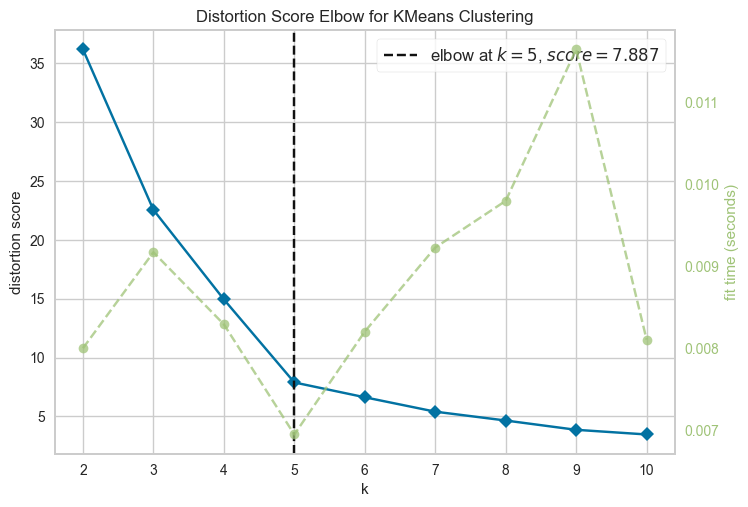

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
# elbow plot
visualizer = KElbowVisualizer(KMeans(random_state = 42), k=(2,11))

visualizer.fit(transform) # Fit the data to the visualizer
visualizer.show()

In [70]:
k_means = KMeans(n_clusters=5, random_state = 42)

# get cluster labels for each park
label = k_means.fit_predict(transform)

u_labels = np.unique(label)

# add cluster label to park
park_sp_df['k_cluster'] = label
k_clus_loc = park_sp_df.merge(locations, how = 'left', left_on = 'park_code', right_on = 'Park Code')
k_clus_loc

,park_code,species_list,k_cluster,Park Code,Park Name,State,Acres,Latitude,Longitude,present
0,ACAD,"[Alces alces, Odocoileus virginianus, Canis la...",0,ACAD,Acadia National Park,ME,47390,44.3500,-68.2100,1
1,ARCH,"[Antilocapra americana, Ovis canadensis, Cervu...",1,ARCH,Arches National Park,UT,76519,38.6800,-109.5700,1
2,BADL,"[Antilocapra americana, Bison bison, Ovis cana...",1,BADL,Badlands National Park,SD,242756,43.7500,-102.5000,1
3,BIBE,"[Antilocapra americana, Ammotragus lervia, Ovi...",1,BIBE,Big Bend National Park,TX,801163,29.2500,-103.2500,1
4,BISC,"[Odocoileus virginianus, Urocyon cinereoargent...",4,BISC,Biscayne National Park,FL,172924,25.6500,-80.0800,1
...,...,...,...,...,...,...,...,...,...,...
56,INDU,"[Odocoileus virginianus, Canis familiaris, Can...",0,INDU,Indiana Dunes National Park,IN,15066,41.6506,-87.0708,0
57,NPSA,"[Sus scrofa, Felis catus, Megaptera novaeangli...",4,NPSA,National Park of American Samoa,AS,13500,14.2583,170.6833,0
58,NERI,"[Odocoileus virginianus, Canis latrans, Canis ...",0,NERI,New River Gorge National Park,WV,72808,37.8752,-81.0357,0
59,VIIS,"[Capra hircus, Odocoileus virginianus, Sus scr...",4,VIIS,Virgin Islands National Park,VI,12909,18.3435,64.7501,0


In [73]:
location_list = k_clus_loc[['Latitude', 'Longitude']].values.tolist()
park_names = k_clus_loc['Park Name'].tolist()

k_clus_loc['color'] = k_clus_loc.apply(regioncolors, axis = 1)
k_clus_loc[k_clus_loc['k_cluster'] == 4]
k_clus_loc = k_clus_loc.dropna().reset_index(drop = True)

In [74]:
us_map = folium.Map(tiles='CartoDB positron', zoom_start=14)

for point in range(0, len(location_list)):
    folium.Marker(location_list[point],popup=park_names[point], icon=folium.Icon(color=k_clus_loc["color"][point], icon_color='white', icon='star', angle=0, prefix='fa')).add_to(us_map)

display(us_map)